# Signal correction and CDS recovery

Now let's implement the signal correction steps described in the [Calibrating and Binning Ariel Data](https://www.kaggle.com/code/gordonyip/calibrating-and-binning-ariel-data) notebooks from the competition organizers. Here are the steps:

1. Analog-to-Digital Conversion
2. Mask hot/dead pixel
3. Linearity Correction
4. Dark current subtraction
5. Get Correlated Double Sampling (CDS)
6. Flat Field Correction

## Notebook set-up

In [ ]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
import itertools

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy.stats import sigma_clip

# Local imports
import configuration as config

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Load assets

In [2]:
airs_file = f'{config.RAW_DATA_DIRECTORY}/train/{config.SAMPLE_PLANET}/AIRS-CH0_signal_0.parquet'
fgs_file = f'{config.RAW_DATA_DIRECTORY}/train/{config.SAMPLE_PLANET}/FGS1_signal_0.parquet'

airs_signal = pd.read_parquet(airs_file).to_numpy().reshape(11250, 32, 356)

cut_inf, cut_sup = 39, 321
airs_signal = airs_signal[:, :, cut_inf:cut_sup]

fgs_signal = pd.read_parquet(fgs_file).to_numpy().reshape(135000, 32, 32)

axis_info = pd.read_parquet(f'{config.DATA_DIRECTORY}/raw/axis_info.parquet')

planet_path = f'{config.RAW_DATA_DIRECTORY}/train/{config.SAMPLE_PLANET}'

dark_airs = pd.read_parquet(f'{planet_path}/AIRS-CH0_calibration_0/dark.parquet').values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
dead_airs = pd.read_parquet(f'{planet_path}/AIRS-CH0_calibration_0/dead.parquet').values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
dark_fgs = pd.read_parquet(f'{planet_path}/FGS1_calibration_0/dark.parquet').values.astype(np.float64).reshape((32, 32))
dead_fgs = pd.read_parquet(f'{planet_path}/FGS1_calibration_0/dead.parquet').values.astype(np.float64).reshape((32, 32))
airs_linear_corr = pd.read_parquet(f'{planet_path}/AIRS-CH0_calibration_0/linear_corr.parquet').values.astype(np.float64).reshape((6, 32, 356))[:, :, cut_inf:cut_sup]
linear_corr = pd.read_parquet(f'{planet_path}/FGS1_calibration_0/linear_corr.parquet').values.astype(np.float64).reshape((6, 32, 32))
airs_flat = pd.read_parquet(f'{planet_path}/AIRS-CH0_calibration_0/flat.parquet').values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
fgs_flat = pd.read_parquet(f'{planet_path}/FGS1_calibration_0/flat.parquet').values.astype(np.float64).reshape((32, 32))

## 3. Preprocessing for CDS recovery

### 3.1. Analog-to-Digital Conversion

Here are the ADC values from the `adc_info.csv` data file:

```
FGS1_adc_offset,FGS1_adc_gain,AIRS-CH0_adc_offset,AIRS-CH0_adc_gain
-1000.0,0.4369,-1000.0,0.4369
```

In [3]:
def ADC_convert(signal, gain=0.4369, offset=-1000):

    signal = signal.astype(np.float64)
    signal /= gain
    signal += offset

    return signal

In [4]:
airs_signal = ADC_convert(airs_signal)
fgs_signal = ADC_convert(fgs_signal)

### 3.2. Hot/dead pixel mask

In [5]:
def mask_hot_dead(signal, dead, dark):

    hot = sigma_clip(
        dark, sigma=5, maxiters=5
    ).mask
    
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))
    signal = np.ma.masked_where(dead, signal)
    signal = np.ma.masked_where(hot, signal)

    return signal

In [6]:
airs_signal = mask_hot_dead(airs_signal, dead_airs, dark_airs)
fgs_signal = mask_hot_dead(fgs_signal, dead_fgs, dark_fgs)

### 3.3. Linearity correction

In [7]:
def apply_linear_corr(linear_corr, clean_signal):
    
    linear_corr = np.flip(linear_corr, axis=0)
    
    for x, y in itertools.product(
                range(clean_signal.shape[1]), range(clean_signal.shape[2])
            ):
        poli = np.poly1d(linear_corr[:, x, y])
        clean_signal[:, x, y] = poli(clean_signal[:, x, y])

    return clean_signal

In [8]:
airs_signal = apply_linear_corr(airs_linear_corr, airs_signal)
fgs_signal = apply_linear_corr(linear_corr, fgs_signal)

### 3.4. Dark current subtraction

In [9]:
def clean_dark(signal, dead, dark, dt):

    dark = np.ma.masked_where(dead, dark)
    dark = np.tile(dark, (signal.shape[0], 1, 1))

    signal -= dark* dt[:, np.newaxis, np.newaxis]

    return signal

In [10]:
dt_airs = axis_info['AIRS-CH0-integration_time'].dropna().values
dt_airs[1::2] += 0.1 # Why are we adding here - I don't think that is right...

dt_fgs = np.ones(len(fgs_signal))*0.1
dt_fgs[1::2] += 0.1 # This one looks more correct

Gotta double check my reading of the exposure kinetics again...

In [11]:
airs_signal = clean_dark(airs_signal, dead_airs, dark_airs, dt_airs)
fgs_signal = clean_dark(fgs_signal, dead_fgs, dark_fgs, dt_fgs)

### 3.5. Get Correlated Double Sampling (CDS)

In [12]:
def get_cds(signal):
    cds = signal[1::2,:,:] - signal[::2,:,:]

    return cds

In [13]:
airs_signal = get_cds(airs_signal)
fgs_signal = get_cds(fgs_signal)

### 3.6. Flat field correction

In [14]:
def correct_flat_field(flat, dead, signal):

    flat = flat.transpose(1, 0)
    dead = dead.transpose(1, 0)
    flat = np.ma.masked_where(dead, flat)
    flat = np.tile(flat, (signal.shape[0], 1, 1))
    signal = signal / flat

    return signal

In [15]:
airs_signal = airs_signal.transpose(0,2,1)
fgs_signal = fgs_signal.transpose(0,2,1)

airs_signal = correct_flat_field(airs_flat, dead_airs, airs_signal)
fgs_signal = correct_flat_field(fgs_flat, dead_fgs, fgs_signal)

airs_signal = airs_signal.transpose(0,2,1)
fgs_signal = fgs_signal.transpose(0,2,1)

OK, *now* plot...

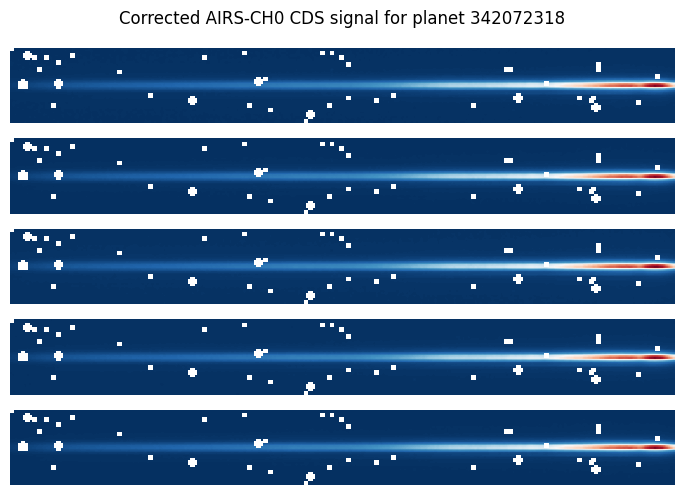

In [16]:
# Plot the first few frames
n_frames = 5
fig, axs = plt.subplots(n_frames, 1, figsize=(10, n_frames))
axs = axs.flatten()

fig.suptitle(f'Corrected AIRS-CH0 CDS signal for planet {config.SAMPLE_PLANET}')

for i in range(n_frames):
    frame = airs_signal[i]        
    frame = frame.astype(float) / np.mean(frame.astype(float))
    im = axs[i].imshow(frame, cmap='RdBu_r')
    axs[i].axis('off')

fig.tight_layout()
fig.savefig('figures/EDA/02.1-corrected_AIRS_CDS_sample_frames.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')

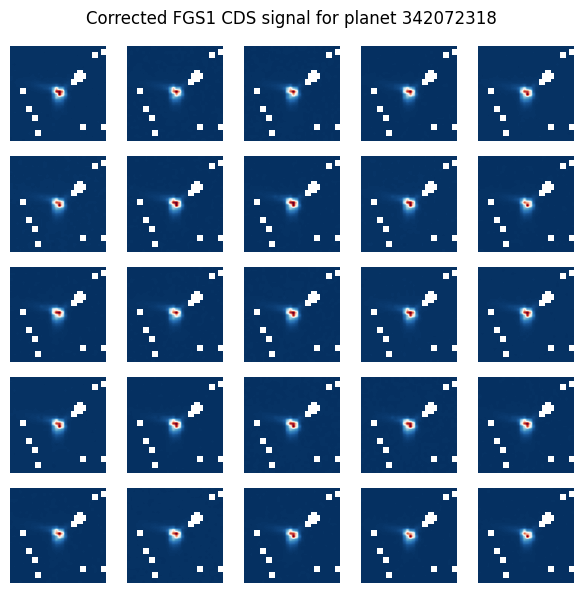

In [17]:
# Plot the first few frames
n_frames = 25
n_dim = int(n_frames**0.5)
dim = n_dim * 2
fig, axs = plt.subplots(n_dim, n_dim, figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH))
axs = axs.flatten()

fig.suptitle(f'Corrected FGS1 CDS signal for planet {config.SAMPLE_PLANET}')

for i in range(n_frames):
    frame = fgs_signal[i]        
    frame = frame.astype(float) / np.mean(frame.astype(float))
    axs[i].imshow(frame, cmap='RdBu_r')
    axs[i].axis('off')

fig.tight_layout()
fig.savefig('figures/EDA/02.1-corrected_FGS1_CDS_sample_frames.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')

Much better! Those blobs are the hot/dead pixels that have been masked out. How does the transit look in the FGS data?

## 5. Exoplanet transits

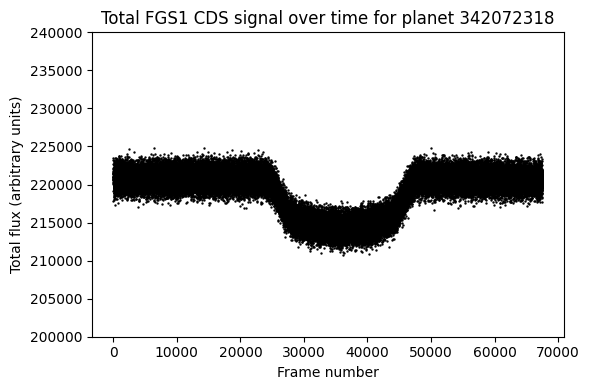

In [23]:
total_flux = [np.sum(frame) for frame in fgs_signal]

plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH - 2))
plt.title(f'Total FGS1 CDS signal over time for planet {config.SAMPLE_PLANET}')
plt.scatter(list(range(len(total_flux))), total_flux, color='black', s=0.5)
plt.xlabel('Frame number')
plt.ylabel('Total flux (arbitrary units)')
plt.ylim(200000, 240000)
plt.savefig('figures/EDA/02.1-corrected_FGS_CDS_transit.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')
plt.tight_layout()
plt.show()

What about the AIRS data?

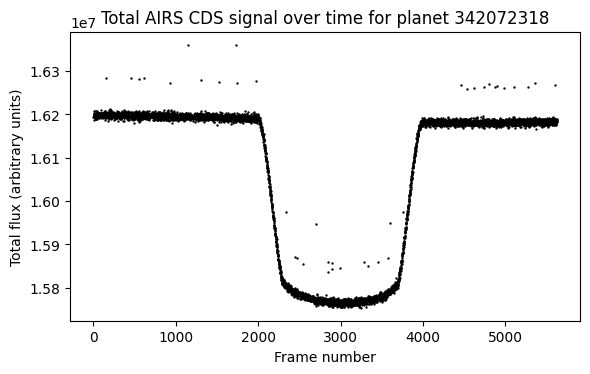

In [19]:
total_flux = [np.sum(frame) for frame in airs_signal]

plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH - 2))
plt.title(f'Total AIRS CDS signal over time for planet {config.SAMPLE_PLANET}')
plt.scatter(list(range(len(total_flux))), total_flux, color='black', s=0.5)
plt.xlabel('Frame number')
plt.ylabel('Total flux (arbitrary units)')
plt.savefig('figures/EDA/02.1-corrected_AIRS_CDS_transit.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')
plt.tight_layout()
plt.show()

Nice! Better than expected. I thought it would be harder to spot the transit in the FGS data. But it's cleaner than the FGS trace. I guess it is a science instrument, not just an alignment camera...

## 6. Summary

Now my concern is time. The six step preprocessing pipeline takes a long time for one planet. We can easily parallelize it - but the Kaggle notebook that we will have to run in only has 4 cores. The good news is we clearly don't need to take the extra step of using the FGS data as a proxy to spot the transit and then get the corresponding time points from the AIRS data. Still thinking we should down sample the FGS data so we have matched time series.

Here's the new plan:

1. Refactor the preprocessing - I think we should be looking at one module for upload to Kaggle to keep the final notebook clean and things simple-ish (the other crazy idea is to make it an installable package on PyPI...).
2. Re-sample the FGS data and keep only time points that are also represented in the AIRS data. It's not like we are going to miss the transit or something, and it will cut the amount of data way down. The example preprocessing function uses binning with sum - but I don't like that.
3. Figure out how to reliably crop the signals out.
4. Figure out how to select a transit and non-transit window from each time series for normalization

Profit? Note: 2, 3, and/or 4 could be done first in the pipeline. They each will reduce the amount of data significantly and in turn speed up the rest of the preprocessing. But, it may be harder to select signal or transits from the un-corrected data. Will have to think about order of operations a bit more as we see each step take shape.